In [2]:
import warnings
warnings.filterwarnings('ignore')

# Import all necessary
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os
import cv2 as cv
import re
import requests

from sklearn.metrics import confusion_matrix,  multilabel_confusion_matrix
from sklearn.preprocessing import MultiLabelBinarizer
from sklearn.model_selection import train_test_split

from keras.models import Sequential
from keras.layers import Conv2D, Dense, Flatten, MaxPooling2D
from keras.layers import BatchNormalization, Activation, Dropout
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import ModelCheckpoint

import tensorflow as tf
import tensorflow_hub as hub

2024-06-24 04:27:36.455622: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-06-24 04:27:36.455737: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-06-24 04:27:36.608148: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [3]:
import os
import shutil
import random

source_dir = '/kaggle/input/new-data-fashion/Apparel images dataset new'
dest_dir = '/kaggle/working/'

# Define the ratio for splitting the data
split_ratio = [0.8, 0.2]  # for training and validation

# Create the destination directories if they don't exist
if not os.path.exists(dest_dir):
    os.makedirs(dest_dir)
for subset in ['training', 'validation']:
    subset_dir = os.path.join(dest_dir, subset)
    if not os.path.exists(subset_dir):
        os.makedirs(subset_dir)

# Loop through each class in the source directory
for class_dir in os.listdir(source_dir):
    class_path = os.path.join(source_dir, class_dir)

    # Create the class directories in the destination folders
    for subset in ['training', 'validation']:
        subset_class_dir = os.path.join(dest_dir, subset, class_dir)
        if not os.path.exists(subset_class_dir):
            os.makedirs(subset_class_dir)

    # Loop through each image in the class directory
    images = os.listdir(class_path)
    random.shuffle(images)  # shuffle the images before splitting

    # Split the images based on the ratio
    splits = [int(len(images) * ratio) for ratio in split_ratio]
    start = 0
    for i, end in enumerate(splits):
        subset_path = os.path.join(dest_dir, ['training', 'validation'][i], class_dir)
        for img in images[start:end]:
            shutil.copy(os.path.join(class_path, img), subset_path)
        start = end

In [4]:
# Lists to store images data and labels
X = []
Y = []

# Input shape for ANN and also to resize images 
input_shape = (96, 96, 3)

# Merge train and test data into one dataset
# Loop through train and test subsets
for subset in ('training', 'validation'):
    path_to_subset = f'/kaggle/working/{subset}'
    
    # Loop through all classes in subset
    for folder in os.listdir(path_to_subset):
        
        # Loop through all images in each class
        for image in os.listdir(os.path.join(path_to_subset, folder)):
            # Defining path to image
            path_to_image = os.path.join(path_to_subset, folder, image)
            # Reading image using cv2
            image = cv.imread(path_to_image)
            # Resizing image
            image = cv.resize(image, (input_shape[1], input_shape[0]))
            # Extracting labels from 'path_to_image' using regex
            label = re.findall(r'\w+\_\w+', path_to_image)[0].split('_')
            
            # Appending data and labels to X and Y lists
            X.append(image)
            Y.append(label)

# Convert X to numpy array and scale values between 0 and 1
X = np.array(X) / 255.0
Y = np.array(Y)

# Binarize labels
mlb = MultiLabelBinarizer()
Y = mlb.fit_transform(Y)

In [5]:
# mlb classes and example of binarized label
print(mlb.classes_)
print(Y[0])

['black' 'blue' 'dress' 'pants' 'shirt' 'shoes' 'shorts']
[0 1 0 0 0 0 1]


In [6]:
# test_x and test_y will be used for final predictions
x, test_x, y, test_y = train_test_split(X, Y, test_size = 0.15, stratify = Y, shuffle = True, random_state = 1)
# train_x, val_x, train_y, val_y will be used to train model and validate results during training
train_x, val_x, train_y, val_y = train_test_split(x, y, test_size = 0.15, stratify = y, shuffle = True, random_state = 1)

print(x.shape, test_x.shape, y.shape, test_y.shape)
print(train_x.shape, val_x.shape, train_y.shape, val_y.shape)

# I'll use ImageDataGenerator to apply random transformations to images
datagen = ImageDataGenerator(rotation_range = 45,
                            width_shift_range = 0.1,
                            height_shift_range = 0.1,
                            zoom_range = 0.2,
                            horizontal_flip = True,
                            validation_split = 0.2)

(4071, 96, 96, 3) (719, 96, 96, 3) (4071, 7) (719, 7)
(3460, 96, 96, 3) (611, 96, 96, 3) (3460, 7) (611, 7)


In [8]:
# Checkpoint to save best model
from tensorflow.keras.callbacks import Callback, EarlyStopping,ModelCheckpoint, ReduceLROnPlateau
checkpoint_path = '/kaggle/working/model_checkpoint.keras'
checkpoint_callback = ModelCheckpoint(checkpoint_path,
                                      save_weights_only=False,
                                      monitor="val_accuracy",
                                      mode = 'auto',
                                      save_best_only=True,
                                     verbose=1)

# Setup EarlyStopping callback to stop training if model's val_loss doesn't improve for 3 epochs
early_stopping = EarlyStopping(monitor = "val_loss", # watch the val loss metric
                               patience = 5,
                               restore_best_weights = True) # if val loss decreases for 3 epochs in a row, stop training

reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=3, min_lr=1e-6)

In [9]:
# Creating model architecture
model = Sequential()

model.add(Conv2D(32, 3, padding = 'same', input_shape = input_shape, kernel_initializer = 'he_normal', activation = 'relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(3))
model.add(Dropout(0.25))

model.add(Conv2D(64, 3, padding = 'same', kernel_initializer = 'he_normal', activation = 'relu'))
model.add(BatchNormalization())
model.add(Conv2D(64, 3, padding = 'same', kernel_initializer = 'he_normal', activation = 'relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D())
model.add(Dropout(0.25))

model.add(Conv2D(128, 3, padding = 'same', kernel_initializer = 'he_normal', activation = 'relu'))
model.add(BatchNormalization())
model.add(Conv2D(128, 2, padding = 'same', kernel_initializer = 'he_normal', activation = 'relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D())
model.add(Dropout(0.25))

model.add(Flatten())
model.add(Dense(1024, activation = 'relu', kernel_initializer = 'he_normal'))
model.add(BatchNormalization())
model.add(Dropout(0.5))

# model.summary()

# use a *softmax* activation for single-label classification
# and *sigmoid* activation for multi-label classification
model.add(Dense(len(mlb.classes_), activation = 'sigmoid'))

In [10]:
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 96, 96, 32)     │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 96, 96, 32)     │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 32, 32, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 32, 32, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 32, 32, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 32, 32, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 32, 32, 64)     │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 32, 32, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 16, 16, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 16, 16, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 16, 16, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_3           │ (None, 16, 16, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (None, 16, 16, 128)    │        65,664 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_4           │ (None, 16, 16, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 8, 8, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 8, 8, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 8192)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 1024)           │     8,389,632 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_5           │ (None, 1024)           │         4,096 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 1024)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 7)              │         7,175 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 8,598,407 (32.80 MB)

 Trainable params: 8,595,527 (32.79 MB)

 Non-trainable params: 2,880 (11.25 KB)

In [11]:
model.compile(optimizer = 'adam', loss = 'binary_crossentropy', metrics = ['accuracy'])

In [12]:
history = model.fit(datagen.flow(train_x, train_y, batch_size = 64),
                             validation_data = (val_x, val_y), epochs = 100, verbose = 1, callbacks = [early_stopping,checkpoint_callback,reduce_lr])

Epoch 1/100
 1/55 ━━━━━━━━━━━━━━━━━━━━ 14:42 16s/step - accuracy: 0.0000e+00 - loss: 1.1097

I0000 00:00:1719203360.338657     149 device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.
W0000 00:00:1719203360.364195     149 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


 4/55 ━━━━━━━━━━━━━━━━━━━━ 3:07 4s/step - accuracy: 0.2798 - loss: 0.9841 

W0000 00:00:1719203371.211887     148 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


54/55 ━━━━━━━━━━━━━━━━━━━━ 0s 327ms/step - accuracy: 0.5966 - loss: 0.6741

W0000 00:00:1719203379.629758     149 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update



Epoch 1: val_accuracy improved from -inf to 0.46809, saving model to /kaggle/working/model_checkpoint.keras


W0000 00:00:1719203380.760660     151 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


55/55 ━━━━━━━━━━━━━━━━━━━━ 37s 389ms/step - accuracy: 0.6009 - loss: 0.6693 - val_accuracy: 0.4681 - val_loss: 0.6129 - learning_rate: 0.0010
Epoch 2/100
54/55 ━━━━━━━━━━━━━━━━━━━━ 0s 128ms/step - accuracy: 0.8442 - loss: 0.3424
Epoch 2: val_accuracy improved from 0.46809 to 0.46972, saving model to /kaggle/working/model_checkpoint.keras
55/55 ━━━━━━━━━━━━━━━━━━━━ 8s 138ms/step - accuracy: 0.8448 - loss: 0.3415 - val_accuracy: 0.4697 - val_loss: 0.9087 - learning_rate: 0.0010
Epoch 3/100
54/55 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step - accuracy: 0.8725 - loss: 0.2600
Epoch 3: val_accuracy did not improve from 0.46972
55/55 ━━━━━━━━━━━━━━━━━━━━ 8s 125ms/step - accuracy: 0.8722 - loss: 0.2598 - val_accuracy: 0.4615 - val_loss: 0.7161 - learning_rate: 0.0010
Epoch 4/100
54/55 ━━━━━━━━━━━━━━━━━━━━ 0s 124ms/step - accuracy: 0.8632 - loss: 0.2263
Epoch 4: val_accuracy improved from 0.46972 to 0.49100, saving model to /kaggle/working/model_checkpoint.keras
55/55 ━━━━━━━━━━━━━━━━━━━━ 8s 133ms/step -

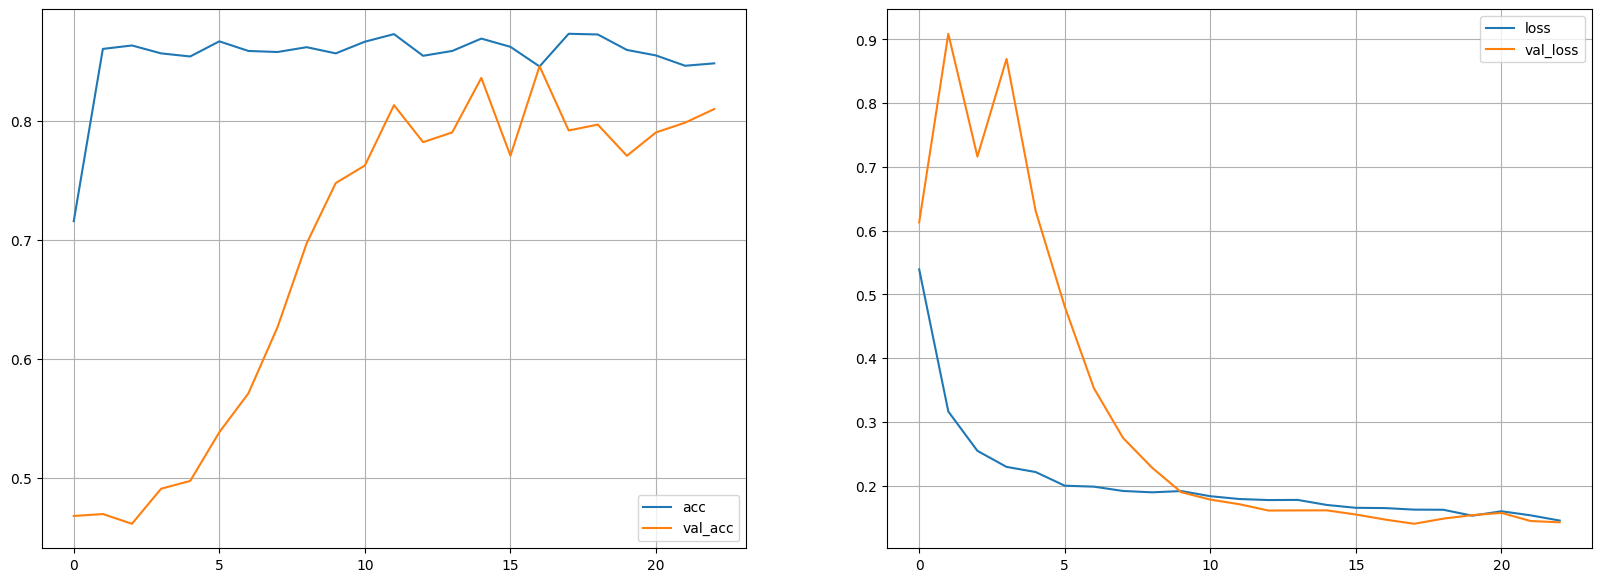

In [13]:
# Plot training results
H = history.history
fig = plt.figure(figsize = (20, 7))
plt.subplot(121)
plt.plot(H['accuracy'], label = 'acc')
plt.plot(H['val_accuracy'], label = 'val_acc')
plt.grid()
plt.legend()

plt.subplot(122)
plt.plot(H['loss'], label = 'loss')
plt.plot(H['val_loss'], label = 'val_loss')
plt.grid()
plt.legend()

23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step


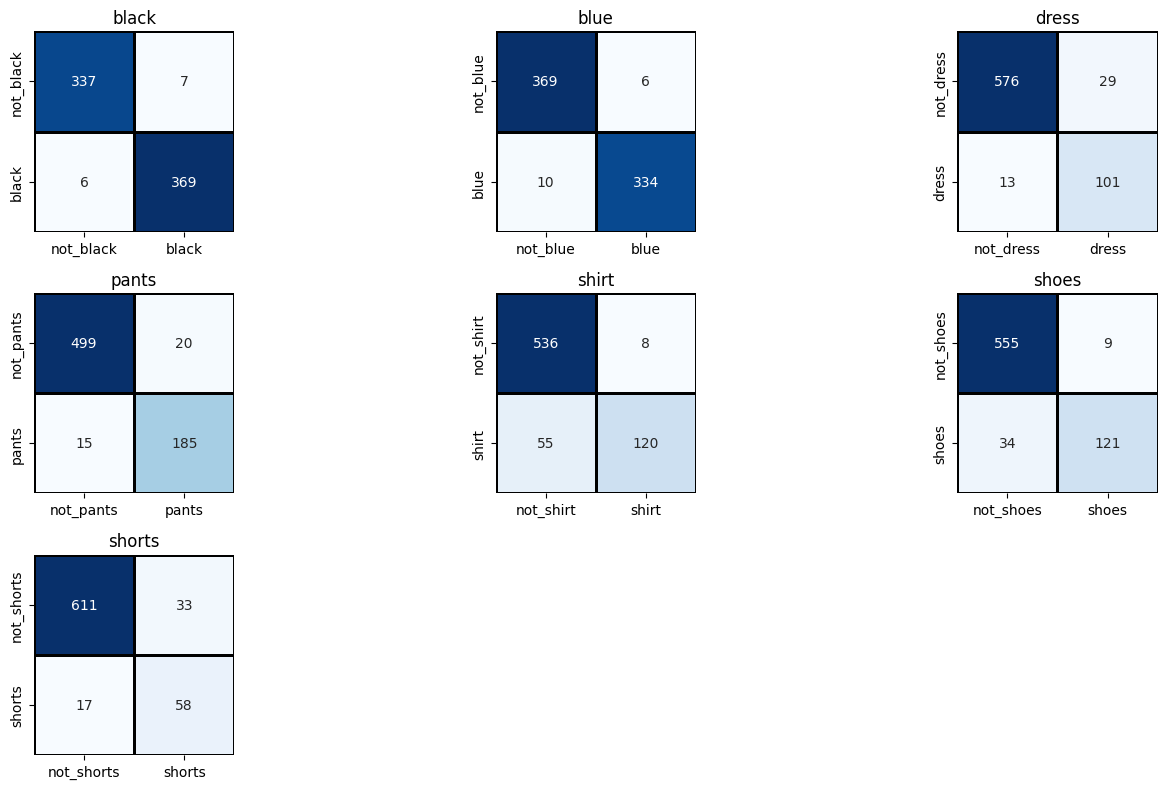

In [17]:
import math

# Loading best weights
model.load_weights('/kaggle/working/model_checkpoint.keras')
# Save model for later usage
model.save('/kaggle/working/model_checkpoint.keras')

# Predicting test images
preds = model.predict(test_x)
preds = np.where(preds < 0.5, 0, 1)

# Creating multilabel confusion matrix
confusion = multilabel_confusion_matrix(test_y, preds)

# Determine grid size
num_labels = len(mlb.classes_)
grid_size = math.ceil(math.sqrt(num_labels))

# Plot confusion matrix 
fig = plt.figure(figsize=(14, 8))
for i, (label, matrix) in enumerate(zip(mlb.classes_, confusion)):
    plt.subplot(grid_size, grid_size, i + 1)
    labels = [f'not_{label}', label]
    sns.heatmap(matrix, annot=True, square=True, fmt='d', cbar=False, cmap='Blues', 
                xticklabels=labels, yticklabels=labels, linecolor='black', linewidth=1)
    plt.title(label)

plt.tight_layout()
plt.show()


In [24]:
len(test_y)

719

In [26]:
len(test_x)

719

In [29]:
from sklearn.metrics import classification_report

preds = model.predict(test_x)
preds = np.where(preds < 0.5, 0, 1)
report = classification_report(test_y, preds, output_dict=True)
df = pd.DataFrame(report).transpose()
df

23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step


,precision,recall,f1-score,support
0,0.981383,0.984000,0.982690,375.0
1,0.982353,0.970930,0.976608,344.0
2,0.776923,0.885965,0.827869,114.0
3,0.902439,0.925000,0.913580,200.0
4,0.937500,0.685714,0.792079,175.0
5,0.930769,0.780645,0.849123,155.0
6,0.637363,0.773333,0.698795,75.0
micro avg,0.920000,0.895688,0.907681,1438.0
macro avg,0.878390,0.857941,0.862963,1438.0
weighted avg,0.925688,0.895688,0.906949,1438.0


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


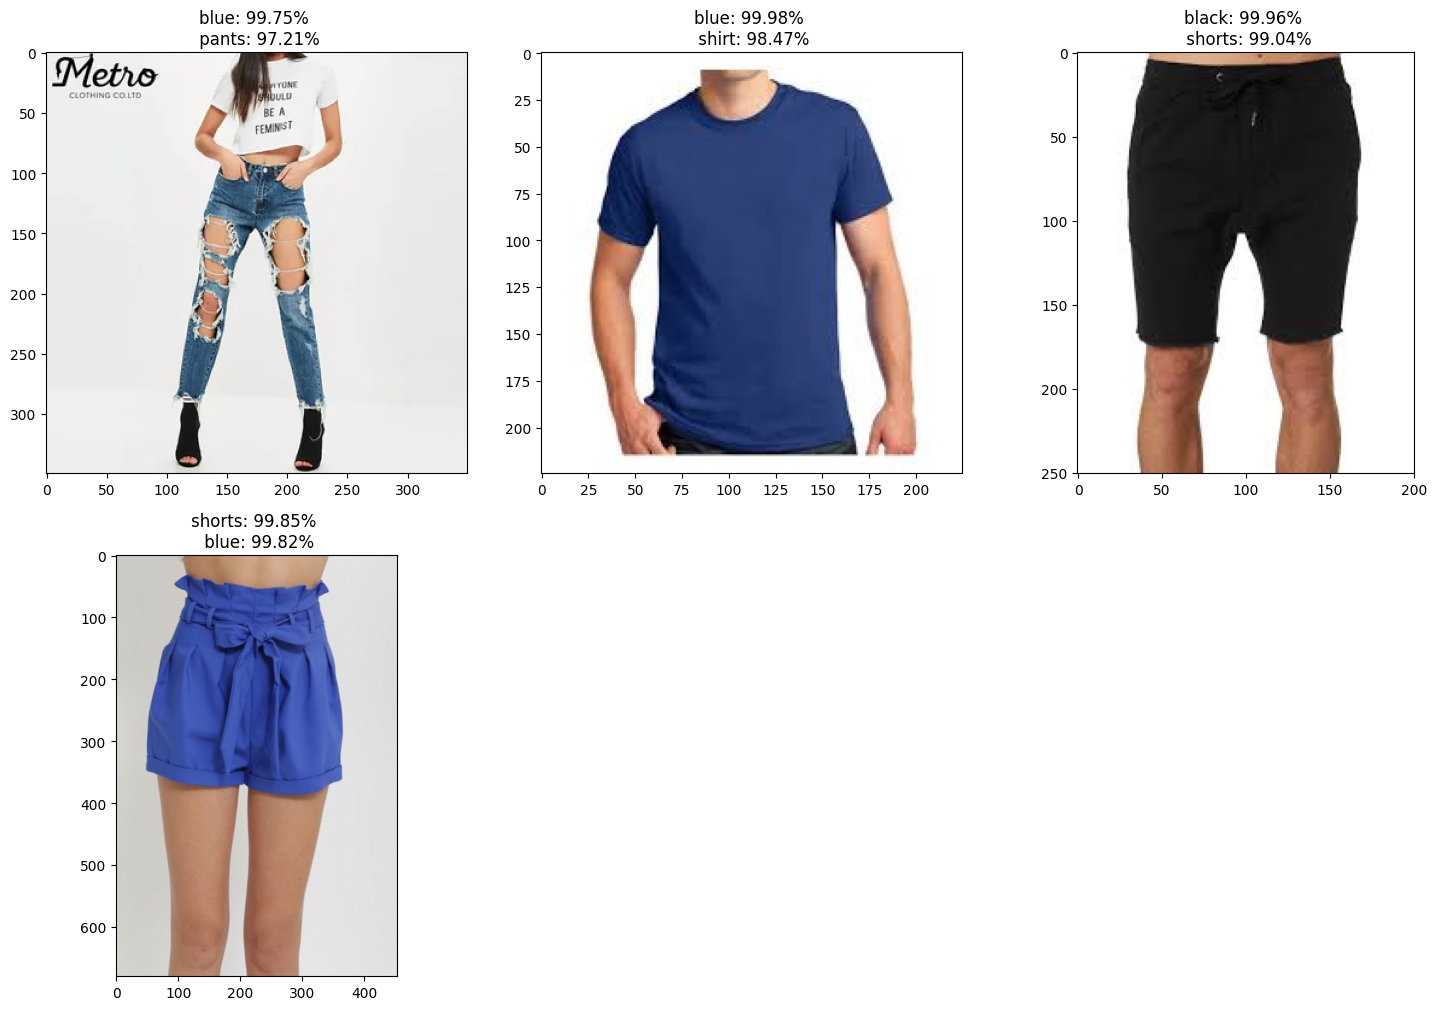

In [30]:
import matplotlib.pyplot as plt
import numpy as np
import cv2 as cv
import requests

# Assuming `model` and `mlb` are defined elsewhere and `input_shape` is available
# Also assuming necessary imports are already made

urls = [
    'https://sc02.alicdn.com/kf/HTB1QbZ_dzgy_uJjSZJnq6zuOXXaq/Wholesale-scratch-pants-damaged-denim-women-s.jpg_350x350.jpg',
    'https://encrypted-tbn0.gstatic.com/images?q=tbn%3AANd9GcSFA1Q-O44dQWt1lvsnOQyoMcQ3myaxY-GscMHgmPtmyWT14ZJU',
    'https://encrypted-tbn0.gstatic.com/images?q=tbn%3AANd9GcTJYyBOAy35RM7m0JzNGHo_-VTSf6bPMh9hACbhhqxsdoMXHQvD',
    'https://cdn.shopify.com/s/files/1/1359/6121/products/7481209_LF0A0919_1024x1024.jpg?v=1511982241',     
]

fig = plt.figure(figsize=(15, 15))

for i, url in enumerate(urls):
    plt.subplot(3, 3, i + 1)
    
    try:
        # Sending request to the URL
        r = requests.get(url, stream=True).raw
        
        # Reading image, convert it to np array and decode
        image = np.asarray(bytearray(r.read()), dtype="uint8")
        image = cv.imdecode(image, cv.IMREAD_COLOR)
        
        # Check if the image was correctly read
        if image is None:
            raise ValueError("Could not read image from the URL.")
        
        # Resize, scale and reshape image before making predictions
        resized = cv.resize(image, (input_shape[1], input_shape[0]))
        resized = (resized / 255.0).reshape(-1, input_shape[1], input_shape[0], input_shape[2])
        
        # Predict results
        preds = model.predict(resized)
        preds = zip(list(mlb.classes_), list(preds[0]))
        preds = sorted(list(preds), key=lambda z: z[1], reverse=True)[:2]
        
        # Showing image
        plt.imshow(cv.cvtColor(image, cv.COLOR_BGR2RGB))
        plt.title(f'{preds[0][0]}: {round(preds[0][1] * 100, 2)}% \n {preds[1][0]}: {round(preds[1][1] * 100, 2)}%')
    
    except Exception as e:
        plt.title("Error loading image")
        print(f"Error loading image from URL {url}: {e}")
    
plt.tight_layout()
plt.show()